### Training

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from diffmd.solvers import odeint_adjoint
from diffmd.utils import compute_grad
from diffmd.utils import body_to_lab_frame, lab_to_body_frame, quat_to_euler_angles
from analysis.reader import Reader


import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
import os
import shutil
# TODO: fix quaternion module warning because of NUMBA
import quaternion
from torchviz import make_dot # visualize computation graphs

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print(f'Using {device} device')

class RunningAverageMeter(object):
    """Computes and stores the average and current value"""

    def __init__(self, momentum=0.99):
        self.momentum = momentum
        self.losses = []
        self.reset()

    def reset(self):
        self.val = None
        self.avg = 0

    def update(self, val):
        if self.val is None:
            self.avg = val
        else:
            self.avg = self.avg * self.momentum + val * (1 - self.momentum)
        self.val = val
        self.log(val)
    
    def log(self, val):
        self.losses.append(val)

def get_first_batch(trajs,nsample,sampleLength,dt):
    twice_dim = trajs.size()[2]
    dim = twice_dim//2
    
    q0 = trajs[0:nsample, 0, :dim].to(device)
    p0 = trajs[0:nsample, 0, dim:].to(device)
    batch_y0 = (p0, q0)
    
    q = trajs[0:nsample, 0:sampleLength, :dim].to(device)
    p = trajs[0:nsample, 0:sampleLength, dim:].to(device)
    batch_y = torch.cat((p, q), dim=2).swapaxes(0, 1)
    
    batch_t = torch.linspace(0.0,dt*(sampleLength-1),sampleLength).to(device)
    return batch_t, batch_y0, batch_y

class ODEFunc(nn.Module):
    def __init__(self, nparticles, inertia, k, dim, width, depth):
        super(ODEFunc, self).__init__()
        self.dim = dim
        self.nparticles = nparticles
        layers = []
        for i in range(depth):
            if i == 0:
                # first layer takes in all configurational variables (xyz and quaternions)
                layers += [nn.Linear(self.dim, width), nn.Sigmoid()]
            if i == (depth-1):
                # last layer outputs a single potential energy value
                layers += [nn.Linear(width, 1)]
            else:
                layers += [nn.Linear(width, width), nn.Sigmoid()]
        self.net = nn.Sequential(*layers).type(torch.float64)

        for m in self.net.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)

        # testing only translational motion
        layers = []
        for i in range(depth):
            if i == 0:
                # first layer takes in all configurational variables (xyz and quaternions)
                layers += [nn.Linear(1, width), nn.Sigmoid()]
            if i == (depth-1):
                # last layer outputs a single potential energy value
                layers += [nn.Linear(width, 1)]
            else:
                layers += [nn.Linear(width, width), nn.Sigmoid()]
        self.trans_net = nn.Sequential(*layers).type(torch.float64)

        for m in self.trans_net.modules():
            if isinstance(m,nn.Linear):
                nn.init.normal_(m.weight,mean=0,std=0.01)
                nn.init.constant_(m.bias,val=0)


        # HACK
        self.mass = 7.0
        self.inertia = inertia
        self.k = k

    def forward(self, state):

        with torch.set_grad_enabled(True):    
            # TODO: make sure batching and dimensions are sent appropriately
            v = state[0]
            # print(v.requires_grad)
            w = state[1]
            x = state[2] # [number of bodies, number of trajectories, number of dimensions]
            q = state[3]
            
            x.requires_grad = True
            q.requires_grad = True
            
            # normalise quaternions to unit length
            q = q / torch.norm(q, dim=2).unsqueeze(2)
            assert torch.norm(q, dim=2).max() < 1.001, 'quaternions not normalised'
            
            # get separation between bodies
            r_vector = x[0, :, :] - x[1, :, :]
            r = torch.norm(r_vector, dim=-1).unsqueeze(1)
            r_vector = r_vector / r
            
            assert torch.norm(r_vector, dim=1).max() < 1.1, 'separation vector not normalised'
            
            # TODO: is this the corect way to get euler angles? is the correct implementation in terms of the cosine and sine formula?
            # TODO: test out different conventions of how to interpret quaternions
            # TODO: write simple unit tests to check we are truly using the correct convention
            # theta = quat_to_euler_angles(q).view(-1, 2*3)
            # print(theta.shape)

            # rtheta = torch.cat((r, theta), dim=1).view(-1, 2*3+1)
            # print(rtheta.shape)
            # torch.set_printoptions(profile="full")
            # print(rtheta)
            # TODO: check that harmonic restraint is calculated correctly
            # u = self.net(rtheta) - self.harmonic_restraint(r) # [potential energy, number of trajectories]
            # fT = -compute_grad(inputs=rtheta, output=u.T) # [force _ torque, number of trajectories]
            
            # testing out only trans motion
            u = self.trans_net(r) - self.harmonic_restraint(r) # [potential energy, number of trajectories]
            # print(u)
            f = -compute_grad(inputs=r, output=u.T) 
            
            # HACK: make sure we are splitting based on number of coordinates
            # f, T = torch.split(fT, [1, 6], dim=1) # capital T means in lab coordinates
            
            T = torch.zeros((f.shape[0], 6)).to(device)
            # TODO: do this without assigning variables to speed up computation
            fA = - f * r_vector # [force, number of trajectories]
            fB = f * r_vector
            f = torch.stack((fA, fB), dim=0)
            
            
            # TODO; do the torque thing

            # translational motion
            # HACK: same mass for all bodies
            dvdt = f / self.mass
            # print('dvdt', torch.norm(dvdt, dim=[0, 2]).mean()* time_step * log_freq)
            dxdt = v

            # print('dxdt', torch.norm(dxdt, dim=[0, 2]).mean() * time_step * log_freq)


            # rotational motion
            q_conj = torch.cat((q[:, :, 0:1], -q[:, :, 1:]), dim=2) # get conguarient quaternions
            dLdt = torch.cat((torch.zeros(q.shape[0], q.shape[1], 1).to(device), T.reshape(2, -1, 3)), dim=2) # [number of bodies, number of trajectories, 4]
            dldt = q * dLdt * q_conj
            dwdt = dldt[:, :, 1:] / self.inertia[:, None, :]
            dqdt = (0.5 * body_to_lab_frame(w) @ q[:, :, :, None]).squeeze()
            assert torch.all(dqdt[0, 0, :] == (0.5 * body_to_lab_frame(w)[0, 0, :, :] @ q[0, 0, :, None]).squeeze()), 'dqdt tensor update is incorrect'

        return (dvdt, dwdt, dxdt, dqdt)

    def harmonic_restraint(self, diff):
        # TODO: train different ks separately, or do a batch of k spring constants, that you update with each get_batch?
        return 0.5 * self.k * torch.square(diff)

    # def compute_grad(self, q, dq):
    #     # using this over compute_grad from nff seems to make no difference
    #     # HACK: does this only work with q_n => n=1? 
    #     return (self.net(q+dq) - self.net(q-dq)) / (2 * dq)

def get_data():
    # train_split = 0.9
    # test_split = 1 - train_split
    df = pd.read_csv(file_name+'-reduced_traj.csv')
    # HACK: do this based on the column names, not explicitly
    com = ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]', 'c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']
    q = ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', 'c_q_1[4]', 'c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', 'c_q_2[4]']
    vel = ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]', 'c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]'] 
    av = ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]', 'c_av_2[1]', 'c_av_2[2]', 'c_av_2[3]']
    am = ['c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]', 'c_am_2[1]', 'c_am_2[2]', 'c_am_2[3]']
    inertia = ['c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]', 'c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]']
    
    centre_of_masses = df.loc[:, ['timestep', *com]]
    quaternions = df.loc[:, ['timestep', *q]]
    velocities = df.loc[:, ['timestep', *vel]]
    ang_velocities = df.loc[:, ['timestep', *av]]
    ang_momenta = df.loc[:, ['timestep', *am]]
    # inertia = df.loc[0, ['timestep', *inertia]]
    inertia = df.loc[:, ['timestep', *inertia]]
    # TODO: use DataLoaders?
    
    # trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    # split_index = int(trajs.shape[0] * train_split)

    # np.random.shuffle(trajs)
    # training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    # testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia

def process_inertia(inertia):
    assert np.all(inertia.std().iloc[1:].to_numpy() == 0), 'inertia is not constant'
    inertia = inertia.iloc[0, 1:].to_numpy().reshape(2, 3)
    return torch.from_numpy(inertia).to(device)

def process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia):
    # HACK: send a single trajectory
    ntraj = 1

    # HACK: pair potential
    nparticles = 2
    vel_dim = 3
    angvel_dim = 3
    com_dim = 3
    quat_dim = 4

    # Get centre of masses
    com1 = centre_of_masses.loc[:, ['c_com_1[1]', 'c_com_1[2]', 'c_com_1[3]']].to_numpy()
    com2 = centre_of_masses.loc[:, ['c_com_2[1]', 'c_com_2[2]', 'c_com_2[3]']].to_numpy()
    # separation = np.linalg.norm(com1-com2, axis=1).reshape(-1, 1)
    coms = torch.from_numpy(np.hstack((com1, com2))).to(device).view(ntraj, -1, nparticles, com_dim)
    
    # Get quaternion rotations
    quat1 = quaternions.loc[:, ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', "c_q_1[4]"]].to_numpy()
    quat2 = quaternions.loc[:, ['c_q_2[1]', 'c_q_2[2]', 'c_q_2[3]', "c_q_2[4]"]].to_numpy()
    quats = torch.from_numpy(np.hstack((quat1, quat2))).to(device).view(ntraj, -1, nparticles, quat_dim)
    
    # Get translation velocities
    vel1 = velocities.loc[:, ['c_vel_1[1]', 'c_vel_1[2]', 'c_vel_1[3]']].to_numpy()
    vel2 = velocities.loc[:, ['c_vel_2[1]', 'c_vel_2[2]', 'c_vel_2[3]']].to_numpy() 
    # hexagon_mass = 7.0
    # mom = torch.from_numpy(np.hstack((vel1 * hexagon_mass, vel2 * hexagon_mass))).to(device).view(ntraj, -1, nparticles, vel_dim)
    vel = torch.from_numpy(np.hstack((vel1, vel2))).to(device).view(ntraj, -1, nparticles, vel_dim)

    # Get angular velocities
    ang_mom = torch.from_numpy(ang_momenta.iloc[:, 1:].to_numpy()).to(device).view(ntraj, -1, nparticles, angvel_dim)
    ang_vel = ang_mom / inertia.view(ntraj, -1, nparticles, angvel_dim)
    return (vel, ang_vel, coms, quats)



Using cuda device


/home/jakub/anaconda3/lib/python3.9/site-packages/quaternion/numba_wrapper.py:23: UserWarning: 

!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
Could not import from numba, which means that some
parts of this code may run MUCH more slowly.  You
may wish to install numba.
!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

  warnings.warn(warning_text)


In [17]:
def get_batch_mod(traj, batch_size, batch_length, dt):
    # TODO: change everything from ANGULAR VELOCITY to ANGULAR MOMENTUM
    """
    Get a batch of data from a trajectory.
        
    Args:
        traj (tuple): torch tensors containing the data (velocities, angular velocities, centre of masses, quaternions)
        batch_size (int): number of trajectories in the batch
        batch_length (int): length of each trajectory in the batch
        dt (float): time step
    
    Returns:
        batch_t (torch.Tensor): time steps for the batch
        pos_init (torch.Tensor): initial positions for the batch
        batch_trajs (tuple): batch of torch tensors containing the data (velocities, angular velocities, centre of masses, quaternions - in the form (nparticles, batch_size, batch_length, dim))
    """
    nparticles = trajectory[0].shape[2]
    vel_dim = trajectory[0].size()[3]
    angvel_dim = trajectory[1].size()[3]
    com_dim = trajectory[2].size()[3]
    quat_dim = trajectory[3].size()[3]

    assert vel_dim == 3, 'velocity dimension must be 3'
    assert angvel_dim == 3, 'angular velocity dimension must be 3'
    assert com_dim == 3, 'centre of mass dimension must be 3'
    assert quat_dim == 4, 'quaternion dimension must be 4'

    sampled_is = torch.randint(traj[0].shape[0],size = (batch_size,)).to(device)
    sampled_js = torch.randint(traj[0].shape[1]-batch_length,size = (batch_size,)).to(device)
    # print(sampled_js)
    # sampled_js = torch.zeros((traj[0].shape[1]-batch_length,)).to(device)
    initial_time = sampled_js*dt
   
    batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length).to(device)
    
    vels = torch.swapaxes(traj[0][sampled_is,sampled_js,:,:], 0, 1)
    ang_vels = torch.swapaxes(traj[1][sampled_is,sampled_js,:,:], 0, 1)
    coms = torch.swapaxes(traj[2][sampled_is,sampled_js,:,:], 0, 1)
    quats = torch.swapaxes(traj[3][sampled_is,sampled_js,:,:], 0, 1)
    
    pos_init = (vels, ang_vels, coms, quats)

    sampled_vels = []
    sampled_ang_vels = []
    sampled_coms = []
    sampled_quats = []
    for i in range(batch_size):
        vels = torch.swapaxes(traj[0][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:], 0, 1)
        ang_vels = torch.swapaxes(traj[1][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:], 0, 1)
        coms = torch.swapaxes(traj[2][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:], 0, 1)
        quats = torch.swapaxes(traj[3][sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:], 0, 1)
        
        sampled_vels.append(vels)
        sampled_ang_vels.append(ang_vels)
        sampled_coms.append(coms)
        sampled_quats.append(quats)
        
    sampled_vels = torch.stack(sampled_vels, dim=1).type(torch.float64)
    sampled_ang_vels = torch.stack(sampled_ang_vels, dim=1).type(torch.float64)
    sampled_coms = torch.stack(sampled_coms, dim=1).type(torch.float64)
    sampled_quats = torch.stack(sampled_quats, dim=1).type(torch.float64)
    batch_trajs = (sampled_vels, sampled_ang_vels, sampled_coms, sampled_quats)

    return batch_t, pos_init, batch_trajs


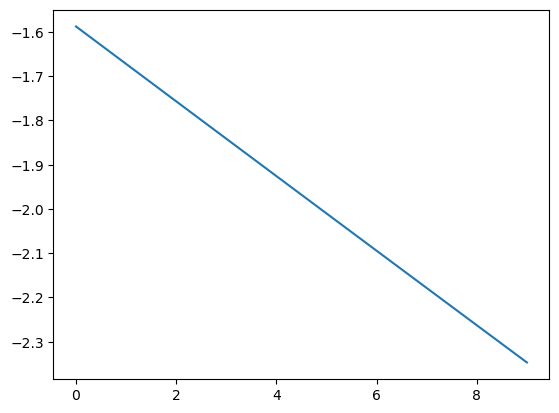

In [42]:
centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()
com = centre_of_masses.iloc[:, 1:4].to_numpy()
vel = velocities.iloc[:, 1:4].to_numpy()
# use phase space to plot how far we are?
# plt.plot(com[:, 0], vel[:, 0])
plt.plot(com[1000:1010, 0])
plt.show()

In [44]:
from diffmd.solvers import odeint_adjoint
torch.manual_seed(5)


if os.path.exists('temp'):
    shutil.rmtree('temp')

if not os.path.exists('temp'):
    os.makedirs('temp')

prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
file_name = prefix+'NVE-temp-2.25_K-0.018140589569161_r-0_s-5'

# prefix = 'hexagons/trajectories/smooth/'
# file_name = prefix+'NVE-temp-0.45_K-0.219478737997257_r-0_s-5'


reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
orig_labels, orig_lines = reader.read_original_traj(save=True)


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()

inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

# Trying to learn dynamics only from centre of masses
quats = torch.zeros_like(trajectory[3])
quats[:, :, :, -1] = 1
trajectory = (trajectory[0], torch.zeros_like(trajectory[1]), trajectory[2], quats)

# Trying to learn on tenth of the trajectory
traj_length = trajectory[0].shape[1]
divider = 1
# print(traj_length)
# plt.plot(trajectory[0][0, :, 0, 0].detach().cpu().numpy())
# plt.show()
trajectory = (trajectory[0][:, :traj_length // divider, :, :], trajectory[1][:, :traj_length // divider, :, :], trajectory[2][:, :traj_length // divider, :, :], trajectory[3][:, :traj_length // divider, :, :])
# assert 0 == 1
# dim = nparticles * ((trajectory[2].size()[-1]) + (trajectory[3].size()[-1])) # add number of quaternions and centre of masses degrees of freedom
dim = 1 + (2 * 3)


niters = 100
nn_width = 50
nn_depth = 2
learning_rate = [1e-3]#[1.0, 0.1, 0.01, 0.001]
nparticles = 2 # trajectory[2].shape[0] ? 
batch_size = 800
batch_length = 10
# HACK: read logging frequency from file and then make dt = dt * log_freq
log_freq = 10000
time_step = 1e-05
dt = time_step * log_freq

losses_log = []

for lr in learning_rate:
    loss_meter = RunningAverageMeter()
    # HACK: harmonic constant - 0.018140589569161
    func = ODEFunc(nparticles, inertia, 0.018140589569161, dim, nn_width, nn_depth).to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=lr)

    for itr in range(1, niters + 1):
        start = time.perf_counter()
        # zero out gradients with less memory operations
        for param in func.parameters():
            param.grad = None
        
        # HACK: to try sending in a trajectory
        batch_t, batch_y0, batch_y = get_batch_mod(trajectory, batch_size, batch_length, dt)   

        # TODO: add assertion to check right dimensions
        pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

        pred_y = torch.cat(pred_y, dim=-1)
        batch_y = torch.swapaxes(torch.swapaxes(torch.cat(batch_y, dim=-1), 0, 2), 1, 2)

        # TODO: there is something fundamentally wrong with the dimensions as the plotted data makes no sense
        # TODO: it currently shows an oscillating behaviour at a weird timescale which is just not true

        # TODO: train only on specifics and not all of the data
        # training only on translational information
        pred_y_trans = torch.cat((pred_y[:, :, :, 0:3], pred_y[:, :, :, 6:9]))
        batch_y_trans = torch.cat((batch_y[:, :, :, 0:3], batch_y[:, :, :, 6:9]))
        
        loss = torch.mean(torch.abs(pred_y_trans - batch_y_trans))
        loss.backward() 
        optimizer.step()
        loss_meter.update(loss.item())
        
        if itr % 100 == 0:
            with torch.no_grad():
                batch_t, batch_y0, batch_y = get_batch_mod(trajectory, 2, 1000, dt)   

                pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

                pred_y = torch.cat(pred_y, dim=-1)            
                batch_y = torch.swapaxes(torch.swapaxes(torch.cat(batch_y, dim=-1), 0, 2), 1, 2)
                # print(batch_y.shape)
                # assert 0 == 1
                ind_vel = [0, 1, 2]
                ind_pos = [6, 7, 8]
                for i in ind_vel:
                    plt.title('velocities')
                    plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,0,0,i], 'k--', alpha=0.3, label=f'true {i}')
                    plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                plt.savefig(f'temp/{itr}_vel.png')
                plt.close()
                for i in ind_pos:
                    plt.title('positions')
                    plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,0,0,i], 'k--', alpha=0.3, label=f'true {i}')
                    plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0,i], 'r-', alpha=0.5, label=f'pred {i}')
                plt.savefig(f'temp/{itr}_pos.png')
                plt.close()
                

        if itr % 10 == 0: # output log throughout
            print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
            print('current loss: {:.4f}'.format(loss_meter.val))
            print('Last iteration took:     ', time.perf_counter() - start)

    print('========================================================')
        
    losses_log.append(loss_meter.losses)
        

Found timestep: 1e-05, n of run steps: 100000000, and dump log freq: 10000
Iter: 10, running avg elbo: 0.0073
current loss: 0.0067
Last iteration took:      0.43710642866790295
Iter: 20, running avg elbo: 0.0073
current loss: 0.0061
Last iteration took:      0.4321589767932892
Iter: 30, running avg elbo: 0.0073
current loss: 0.0075
Last iteration took:      0.4365565702319145
Iter: 40, running avg elbo: 0.0072
current loss: 0.0080
Last iteration took:      0.43502719700336456
Iter: 50, running avg elbo: 0.0072
current loss: 0.0065
Last iteration took:      0.4360312018543482
Iter: 60, running avg elbo: 0.0072
current loss: 0.0064
Last iteration took:      0.43501818366348743
Iter: 70, running avg elbo: 0.0072
current loss: 0.0073
Last iteration took:      0.44860510528087616
Iter: 80, running avg elbo: 0.0072
current loss: 0.0070
Last iteration took:      0.4416044559329748
Iter: 90, running avg elbo: 0.0072
current loss: 0.0073
Last iteration took:      0.4351020995527506
Iter: 100, r

In [23]:
print(10000 * 1e-5)

0.1


In [22]:
print(batch_y.cpu().numpy()[:,0,0,0:3])
v = batch_y.cpu().numpy()[:,0,0,0:3]
print(np.linalg.norm(v[0] - v[1]))

[[ 0.330807    0.466561   -0.539575  ]
 [-0.501856    0.229824   -0.31557   ]
 [ 0.469263    0.00821721  0.360321  ]
 [-0.27629     0.1167     -0.223378  ]
 [ 0.41892    -0.00477013  0.370613  ]
 [ 0.294175    0.740057    0.0249534 ]
 [ 0.444888    0.106165   -0.642416  ]
 [ 0.469263    0.00821721  0.360321  ]
 [-0.313959    0.332104   -0.614065  ]
 [ 0.402951    0.186684   -0.336445  ]
 [ 0.0207267   0.565495    0.0687283 ]
 [-0.308562   -0.241897   -0.120791  ]
 [-0.0624816  -0.38196     0.383526  ]
 [-0.609905    0.486766   -0.397031  ]
 [-0.475348   -0.0299944  -0.309344  ]
 [ 0.431189    0.218114   -0.594781  ]
 [ 0.690777    0.209635    0.202027  ]
 [-0.0624816  -0.38196     0.383526  ]
 [ 0.371419    0.00464408 -0.341709  ]
 [ 0.543647    0.251389    0.394125  ]]
0.8941757762112548


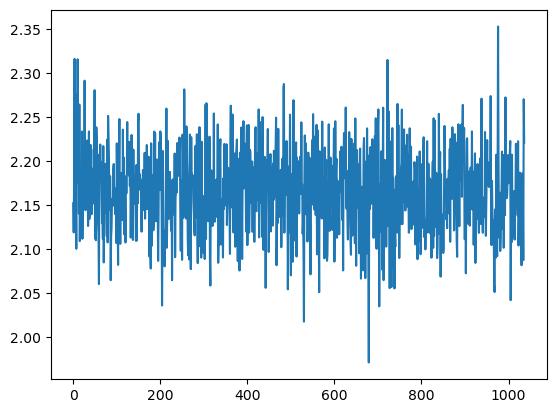

In [91]:
plt.plot(loss_meter.losses)
plt.show()

In [ ]:
from diffmd.solvers import odeint_adjoint

prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
file_name = prefix+'NVE-temp-1.5_K-0.0272108843537415_r-0_s-5'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
orig_labels, orig_lines = reader.read_original_traj(save=True)

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()

inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

niters = 10
nn_width = 50
nn_depth = 3
learning_rate = 1e-1
nparticles = 2 # trajectory[2].shape[0] ? 
batch_size = 10
batch_length = 10

# Trying to learn dynamics only from centre of masses
quats = torch.zeros_like(trajectory[3])
quats[:, :, :, -1] = 1
trajectory = (trajectory[0], torch.zeros_like(trajectory[1]), trajectory[2], quats)

# Trying to learn on tenth of the trajectory
traj_length = trajectory[0].shape[1]
trajectory = (trajectory[0][:, :traj_length // 10, :, :], trajectory[1][:, :traj_length // 10, :, :], trajectory[2][:, :traj_length // 10, :, :], trajectory[3][:, :traj_length // 10, :, :])
print(trajectory[0].shape)

loss_meter = RunningAverageMeter()
# dim = nparticles * ((trajectory[2].size()[-1]) + (trajectory[3].size()[-1])) # add number of quaternions and centre of masses degrees of freedom
dim = nparticles * (3 + 3)
func = ODEFunc(nparticles, inertia, dim, nn_width, nn_depth).to(device)
optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)

for itr in range(1, niters + 1):
    start = time.perf_counter()
    optimizer.zero_grad()

    # HACK: to try sending in a trajectory
    batch_t, batch_y0, batch_y = get_batch_mod(trajectory, batch_size, batch_length, 0.0005)
    pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

    pred_y = torch.cat(pred_y, dim=-1)
    batch_y = torch.cat(batch_y, dim=-1).view(pred_y.shape)
    
    # TODO: train only on specifics and not all of the data
    loss = torch.mean(torch.abs(pred_y - batch_y))
    loss.backward() 
    optimizer.step()
    loss_meter.update(loss.item())
    
    if itr % 250 == 0:
        with torch.no_grad():
            for i in range(6):
                plt.plot(batch_t.cpu().numpy(), batch_y.cpu().numpy()[:,0,0,i], 'k--', alpha=0.3, label=f'true {i}')
                plt.plot(batch_t.cpu().numpy(), pred_y.cpu().numpy()[:,0,0,i], 'r-', label=f'pred {i}')
            plt.show()

    if itr % 10 == 0: # output log throughout
        print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
        print('current loss: {:.4f}'.format(loss_meter.val))
        print('Last iteration took: ', time.perf_counter() - start)

Found timestep: 1e-05, n of run steps: 100000000, and dump log freq: 10000


RuntimeError: CUDA error: CUBLAS_STATUS_INVALID_VALUE when calling `cublasDgemm( handle, opa, opb, m, n, k, &alpha, a, lda, b, ldb, &beta, c, ldc)`

In [95]:
import plotly.graph_objs as go

def vector_plot(tvects,is_vect=True,orig=[0,0,0]):
    """Plot vectors using plotly"""

    if is_vect:
        if not hasattr(orig[0],"__iter__"):
            coords = [[orig,np.sum([orig,v],axis=0)] for v in tvects]
        else:
            coords = [[o,np.sum([o,v],axis=0)] for o,v in zip(orig,tvects)]
    else:
        coords = tvects

    data = []
    for i,c in enumerate(coords):
        X1, Y1, Z1 = zip(c[0])
        X2, Y2, Z2 = zip(c[1])
        vector = go.Scatter3d(x = [X1[0],X2[0]],
                              y = [Y1[0],Y2[0]],
                              z = [Z1[0],Z2[0]],
                              marker = dict(size = [0,5],
                                            color = ['blue'],
                                            line=dict(width=5,
                                                      color='DarkSlateGrey')),
                              name = 'Vector'+str(i+1))
        data.append(vector)

    layout = go.Layout(
             margin = dict(l = 4,
                           r = 4,
                           b = 4,
                           t = 4)
                  )
    fig = go.Figure(data=data,layout=layout)
    fig.show()

In [ ]:
print(trajectory)

(array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.01518218, -0.0139471 ,  0.01710846, ..., -0.0215073 ,
        -0.0290482 , -0.00088951],
       [-0.02682069,  0.0195529 , -0.06787774, ..., -0.173707  ,
        -0.0441775 , -0.0367169 ],
       ...,
       [-0.0213354 ,  0.277402  , -0.0801334 , ...,  0.099064  ,
         0.111093  ,  0.0802596 ],
       [-0.0109809 ,  0.315444  , -0.1316132 , ...,  0.0687512 ,
         0.115968  ,  0.0391946 ],
       [ 0.0974403 ,  0.292485  , -0.0782197 , ...,  0.00388676,
         0.0939857 , -0.0465734 ]]), array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00],
       [ 2.44322943e+00,  9.99824108e-01, -4.29189831e-03,
        -1.81224667e-02, -2.07064793e-03],
       [ 2.42378183e+00,  9.99116925e-01, -4.32879377e-03,
        -3.99009689e-02,  1.23820525e-02],
       ...,
       [ 6.38621611e+00, -7.11082596e-01,  4.32012695e-01,
        

    index  timestep  body_id    id         x         y         z
0      28    1000.0      1.0   1.0  0.989920  0.005859 -0.020850
1      29    1000.0      1.0   2.0  0.495232  0.874905 -0.014301
2      30    1000.0      1.0   3.0 -0.504460  0.881011  0.009731
3      31    1000.0      1.0   4.0 -1.009460  0.018072  0.027215
4      32    1000.0      1.0   5.0 -0.514776 -0.850974  0.020666
5      33    1000.0      1.0   6.0  0.484916 -0.857080 -0.003366
6      34    1000.0      1.0   7.0 -0.009772  0.011965  0.003183
7      35    1000.0      2.0   8.0  2.005380  1.006250  2.004160
8      36    1000.0      2.0   9.0  1.503160  1.870960  1.996230
9      37    1000.0      2.0  10.0  0.503239  1.868330  1.984050
10     38    1000.0      2.0  11.0  0.005532  1.000990  1.979800
11     39    1000.0      2.0  12.0  0.507748  0.136286  1.987730
12     40    1000.0      2.0  13.0  1.507670  0.138914  1.999910
13     41    1000.0      2.0  14.0  1.005450  1.003620  1.991980
          x         y
0  

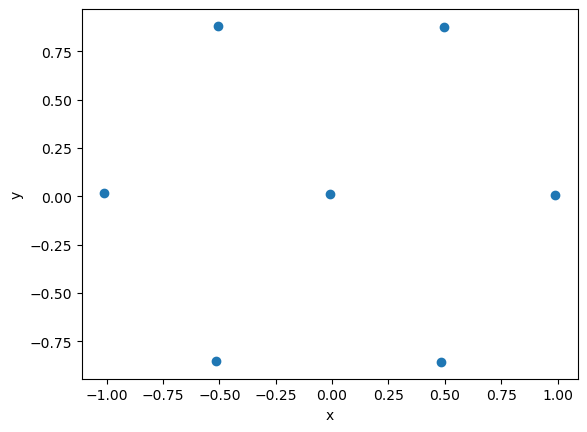

In [ ]:
firstStep = orig_traj.loc[orig_traj['timestep'] == 1000].reset_index()
firstHexagon = firstStep.loc[:6, ['x', 'y']]
print(firstStep)
print(firstHexagon)
plt.plot(firstHexagon.iloc[:, 0], firstHexagon.iloc[:, 1], 'o')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [ ]:
quat1 = quaternions.iloc[:, 0:4].to_numpy()[1:]
ang_vel_1 = ang_velocities.iloc[:, 0:3].to_numpy()
ang_mom_1 = ang_momenta.iloc[:, 0:3].to_numpy()
# print(ang_vel_1)
# print(ang_mom_1)

inertia_1 = ang_mom_1[1:, :] / ang_vel_1[1:, :]
# for i in range(100):
    # print(inertia_1[i])

# quaternion vectors are normalised
# print(np.linalg.norm(quat1[:, 1:], axis=1))



# quaternion package
# print(quat1.shape)
quat1 = quaternion.as_quat_array(quat1)
# print(quat1[0])
# print(quaternion.as_rotation_matrix(quat1)[0])
q = quat1[0]
R = quaternion.as_rotation_matrix(quat1)[0]
# print(q)
vector1 = np.array([2.5, 3.6, 3.7])
vector1_Q = np.quaternion(0, 2.5, 3.6, 3.7)
vector2_R = R @ vector1
vector2_Q = q * vector1_Q * q.conjugate()


# print(q)
# print(q.conjugate())
# print(R.shape)

print(vector2_Q)
print(quaternion.as_float_array(vector2_Q))


vector_plot([vector1, vector2_R, quaternion.as_float_array(vector2_Q)[1:]])




quaternion(6.93889390390723e-18, -2.38796216413147, -3.63768324282903, 3.73695904748035)
[ 6.93889390e-18 -2.38796216e+00 -3.63768324e+00  3.73695905e+00]


In [ ]:
quat1 = quaternions.iloc[:, 0:4].to_numpy()[1:]
quats = quaternion.as_quat_array(quat1[:10])
# consider quaternions to be a rotation from x axis
vector = np.quaternion(0, 1, 0, 0)
print(vector)
vector = quats * vector * quats.conjugate()

# print(quats)
# print(quats.conjugate())
vectors = quaternion.as_float_array(vector)[:, 1:]
# plots subsequent orientations
vector_plot(list(vectors))
print(list(vectors))

quaternion(0, 1, 0, 0)


[array([-0.99969073, -0.00631347,  0.0240322 ]), array([-0.99908286,  0.00160399,  0.04277968]), array([-0.99706856,  0.02358701,  0.07279627]), array([-0.99604604,  0.03336901,  0.08234398]), array([-0.99751062,  0.04460248,  0.05461585]), array([-0.99677454,  0.07958029,  0.01032569]), array([-0.99301676,  0.11074407, -0.04067183]), array([-0.99175207,  0.09744422, -0.08325662]), array([-0.99261598,  0.07128534, -0.09814727]), array([-0.99204744,  0.09161861, -0.08629929])]


In [ ]:
def get_batch_mod(traj,batch_size,batch_length,dt):

  twice_dim = traj.size()[2]
  dim = twice_dim//2
  sampled_is = torch.randint(traj.shape[0],size = (batch_size,)).to(device)
  sampled_js = torch.randint(traj.shape[1]-batch_length,size = (batch_size,)).to(device)
  initial_time = sampled_js*dt

  batch_t = torch.linspace(0.0,dt*(batch_length-1),batch_length).to(device)
  qs = traj[sampled_is,sampled_js,:dim]
  ps = traj[sampled_is,sampled_js,dim:]
  pos_init = (ps, qs)
  # print('p', ps)
  # print('q', qs)

  sampled_trajs = []

  for i in range(batch_size):
      qs = traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,:dim].view(-1,dim)
      ps = traj[sampled_is[i],sampled_js[i]:sampled_js[i]+batch_length,dim:].view(-1,dim)
      x = torch.cat((ps, qs), dim=1)
      sampled_trajs.append(x)

      
  batch_trajs = torch.stack(sampled_trajs,dim=1)
  return batch_t,pos_init,batch_trajs
     

def get_data():
    train_split = 0.9
    test_split = 1 - train_split
    trajs = np.load('data/trajectories/diatomic_spring_narrow.npy')
    split_index = int(trajs.shape[0] * train_split)

    np.random.shuffle(trajs)
    training_trajs = torch.Tensor(trajs[:split_index, :, :]).to(device)
    testing_trajs = torch.Tensor(trajs[split_index:, :, :]).to(device)
    
    return training_trajs, testing_trajs 

def train_model(niters, training_trajs, dt, sample_length, batch_size, learning_rate, nn_depth, nn_width):    
    loss_meter = RunningAverageMeter()
    dim = training_trajs.size()[2] // 2
    func = ODEFunc(dim, nn_width, nn_depth).to(device)
    optimizer = torch.optim.Adam(func.parameters(), lr=learning_rate)

    for itr in range(1, niters + 1):
        start = time.perf_counter()
        optimizer.zero_grad()
        
        batch_t, batch_y0, batch_y = get_batch_mod(training_trajs, batch_size, sample_length,dt)
        
        # convert momentum to velocity (v = p / mu)
        batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
        pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

        # convert velocity to momentum (p = mu * v)
        pred_y = (pred_y[0] * func.mass, pred_y[1])
        pred_y = torch.cat(pred_y, dim=2)
        
        loss = torch.mean(torch.abs(pred_y[:, :, 0] - batch_y[:, :, 0]))
        loss.backward() 
        optimizer.step()
        loss_meter.update(loss.item())
        
        if itr % 10 == 0: # output log throughout
            print('Iter: {}, running avg elbo: {:.4f}'.format(itr, loss_meter.avg))
            print('current loss: {:.4f}'.format(loss_meter.val))
            print('Last iteration took: ', time.perf_counter() - start)

    return func, loss_meter

def test_model(func, testing_trajs, dt):    
    loss_meter = RunningAverageMeter()
    batch_size = testing_trajs.shape[0]
    sample_length = testing_trajs.shape[1]
    batch_t, batch_y0, batch_y = get_first_batch(testing_trajs, batch_size, sample_length, dt)
        
    # convert momentum to velocity (v = p / mu)
    batch_y0 = (batch_y0[0] / func.mass, batch_y0[1])
    pred_y = odeint_adjoint(func, batch_y0, batch_t, method='NVE')

    # convert velocity to momentum (p = mu * v)
    pred_y = (pred_y[0] * func.mass, pred_y[1])
    pred_y = torch.cat(pred_y, dim=2)
    
    loss = torch.mean(torch.abs(pred_y[:, :, 0] - batch_y[:, :, 0]))
    loss_meter.update(loss.item())
    
    return loss_meter

def evaluate_model(sample_length, batch_size, learning_rate, nn_depth, nn_width, activation_function):
    niters = 300
    dt = 0.1
    t0 = time.perf_counter()

    training_trajs, testing_trajs = get_data()
    model, train_loss = train_model(niters, training_trajs, dt, sample_length, batch_size, learning_rate, nn_depth, nn_width)
    training_time = time.perf_counter() - t0

    test_loss = test_model(model, testing_trajs, dt)

    training_and_testing_time = time.perf_counter() - t0
    return train_loss, test_loss, training_time, training_and_testing_time


import sigopt

def run_and_track_in_sigopt():

#   sigopt.log_dataset(DATASET_NAME)
#   sigopt.log_metadata(key="Dataset Source", value=DATASET_SRC)
#   sigopt.log_metadata(key="Feature Eng Pipeline Name", value=FEATURE_ENG_PIPELINE_NAME)
#   sigopt.log_metadata(
#     key="Dataset Rows", value=features.shape[0]
#   )  # assumes features X are like a numpy array with shape
#   sigopt.log_metadata(key="Dataset Columns", value=features.shape[1])
#   sigopt.log_metadata(key="Execution Environment", value="Colab Notebook")
  sigopt.log_model('Neural ODE Simple Harmonic Motion')
  learning_rates = [10**i for i in range(-5, 1)]
  sigopt.params.setdefaults(
    sample_length=np.random.randint(low=3, high=50),
    batch_size=np.random.randint(low=10, high=1000),
    learning_rate=np.random.choice(learning_rates),
    nn_depth=np.random.randint(low=1, high=5),
    nn_width=np.random.randint(low=2, high=50),
    # activation_function=,  
  )

  args = dict(
    sample_length=sigopt.params.sample_length,
    batch_size=sigopt.params.batch_size,
    learning_rate=sigopt.params.learning_rate,
    nn_depth=sigopt.params.nn_depth,
    nn_width=sigopt.params.nn_width,
    activation_function=None,
  )

  train_loss, test_loss, training_time, training_and_validation_time = evaluate_model(**args)

  running_avg_train_loss = train_loss.avg
  running_avg_test_loss = test_loss.avg

  sigopt.log_metric(name="train_loss", value=running_avg_train_loss)
  sigopt.log_metric(name="test_loss", value=running_avg_test_loss)
  sigopt.log_metric(name="training time (s)", value=training_time)
  sigopt.log_metric(name="training and validation time (s)", value=training_and_validation_time)

run_and_track_in_sigopt()

In [ ]:
import matplotlib.pyplot as plt
prefix = 'hexagons/trajectories/dump_2303/'
file_name = prefix+'NVE-temp-0.2_K-0.493827160493827_r-0_s-5'
# prefix = 'hexagons/trajectories/inertia_issue/'
# file_name = prefix+'NVE-temp-0.45_K-0.219478737997257_r-0_s-5'
end_index = 100

centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()

quat_1 = quaternions.loc[:, ['c_q_1[1]', 'c_q_1[2]', 'c_q_1[3]', "c_q_1[4]"]].to_numpy()
# ang_vel_1 = ang_velocities.loc[:, ['c_av_1[1]', 'c_av_1[2]', 'c_av_1[3]']].to_numpy()
ang_mom_1 = ang_momenta.loc[:, ['c_am_1[1]', 'c_am_1[2]', 'c_am_1[3]']].to_numpy()
ang_mom_2 = ang_momenta.loc[:, ['c_am_2[1]', 'c_am_2[2]', 'c_am_2[3]']].to_numpy()
inertia_1 = inertia.loc[0, ['c_i_1[1]', 'c_i_1[2]', 'c_i_1[3]']].to_numpy()
inertia_2 = inertia.loc[0, ['c_i_2[1]', 'c_i_2[2]', 'c_i_2[3]']].to_numpy()
# print(inertia_1)
# print(inertia_2)
# print(ang_mom_1)
# print(ang_mom_1**2 / 2 * inertia_1)
E_k_1 = np.sum(ang_mom_1**2 / 2 * inertia_1, axis=1) 
E_k_2 = np.sum(ang_mom_2**2 / 2 * inertia_2, axis=1)

# Plot energy
plt.plot(E_k_1[:end_index], label='E_k_1')
plt.plot(E_k_2[:end_index], label='E_k_2')
plt.legend()
plt.show()


# # Plot each column of inertia_1 as a separate line
plt.plot(ang_mom_1[:end_index, 0], 'r', label='angmom_x')
plt.plot(ang_mom_1[:end_index, 1], 'g', label='angmom_y')
plt.plot(ang_mom_1[:end_index, 2], 'b', label='angmom_z')
plt.legend()
plt.show()

In [54]:
r = np.load('wtf_r.npy')
x = np.load('wtf_x.npy')
print(r.shape)
print(x.shape)
indices = np.argwhere(np.isnan(r))
print(indices)
for i in indices:
    print('===')
    # print('BOTH ATOMS', x[:, 0, :])
    # print('===')
    print(i)
    a = x[0, i[0], :].squeeze()
    b = x[1, i[0], :].squeeze()
    print(a, b)
    print(np.linalg.norm(a - b))
    

(400, 3)
(2, 400, 3)
[[212   0]
 [212   1]
 [212   2]
 [213   0]
 [213   1]
 [213   2]
 [352   0]
 [352   1]
 [352   2]
 [353   0]
 [353   1]
 [353   2]]
===
[212   0]
[38.2092  48.0992  -9.61882] [38.2092  48.0992  -9.61882]
0.0
===
[212   1]
[38.2092  48.0992  -9.61882] [38.2092  48.0992  -9.61882]
0.0
===
[212   2]
[38.2092  48.0992  -9.61882] [38.2092  48.0992  -9.61882]
0.0
===
[213   0]
[38.468   49.1537  -9.63282] [38.468   49.1537  -9.63282]
0.0
===
[213   1]
[38.468   49.1537  -9.63282] [38.468   49.1537  -9.63282]
0.0
===
[213   2]
[38.468   49.1537  -9.63282] [38.468   49.1537  -9.63282]
0.0
===
[352   0]
[36.1959  43.0231  -5.16176] [36.1959  43.0231  -5.16176]
0.0
===
[352   1]
[36.1959  43.0231  -5.16176] [36.1959  43.0231  -5.16176]
0.0
===
[352   2]
[36.1959  43.0231  -5.16176] [36.1959  43.0231  -5.16176]
0.0
===
[353   0]
[35.602   43.7333  -5.99043] [35.602   43.7333  -5.99043]
0.0
===
[353   1]
[35.602   43.7333  -5.99043] [35.602   43.7333  -5.99043]
0.0
===
[353  

In [66]:
from diffmd.solvers import odeint_adjoint

prefix = 'hexagons/trajectories/dump_2503/cutoff-2.5/'
file_name = prefix+'NVE-temp-1.5_K-0.0272108843537415_r-0_s-5'

reader = Reader(file_name)
# log_labels, log_lines = reader.read_simulation_log()
traj_labels, traj_lines = reader.read_reduced_traj(save=True)
orig_labels, orig_lines = reader.read_original_traj(save=True)


centre_of_masses, quaternions, velocities, ang_velocities, ang_momenta, inertia = get_data()

inertia = process_inertia(inertia)
trajectory = process_data(centre_of_masses, quaternions, velocities, ang_momenta, inertia)

# Get centre of mass positions
x =  trajectory[2].cpu().detach().numpy().squeeze()
diff = x[:, 0, :] - x[:, 1, :]
norm = np.linalg.norm(diff, axis=1)
for n in norm:
    if n == 0:
        print(n)
    if n != n:
        print('NAN')

Found timestep: 1e-05, n of run steps: 100000000, and dump log freq: 10000


In [16]:
a = np.load('debugger_traj.npy')
print(a.shape)
count = 0
for i in a:
    diff = i[0, :, :] - i[1, :, :]
    norm = np.linalg.norm(diff, axis=1)
    for n in norm:
        if n == 0:
            pass
            # print(count)
            print(n)
        if n != n:
            pass
            print('NAN')
    count += 1

diff = a[0, 0, :, :] - a[0, 1, :, :]
for i in diff:
    print(i)

(1, 2, 800, 3)
0.0
0.0
[ 1.4187   4.7227  -4.33923]
[ 3.1509   5.1078  -3.24636]
[-2.8507  -5.0173   3.17461]
[-2.0579  -5.5425   4.97377]
[-0.3201  -0.0764  -0.54938]
[-0.24     -1.1287    1.479228]
[-3.1402   -6.1093    5.548886]
[-2.8149   -6.7021    4.336841]
[-0.0966  -0.3781   0.38296]
[-0.1098  -0.0658  -0.04038]
[ 2.3087    3.2387   -2.470422]
[ 0.949     3.7695   -2.937366]
[-2.3192  -3.489    2.04655]
[-0.8795  -3.3924   3.26336]
[ 6.6548  11.8663  -9.28322]
[ 4.4597  12.044   -9.16687]
[ -5.3239  -12.7314   10.73419]
[ -6.7929   -13.3352     9.379845]
[-0.8418  -0.3327  -0.01143]
[ 0.5616  -0.2698   0.47636]
[ 5.7083   11.5676   -9.129292]
[ 4.964   11.3914  -8.58671]
[ 3.8189   6.4305  -4.60853]
[ 2.5491   7.2687  -5.96236]
[-0.6698  -1.0295   1.11572]
[-0.6274  -1.7611   1.03761]
[ 0.9794   0.9341  -0.50395]
[-0.0655   1.0319  -1.01318]
[-0.1703 -0.0975 -0.0137]
[ 0.3472   0.478   -0.27994]
[ 0.9923   1.301   -1.37737]
[-0.0489   0.7285  -0.18869]
[ 0.0478   -0.6417    0.9

In [135]:
indices = torch.Tensor([2, 4, 6, 9]).type(torch.long)
tensor = torch.rand(10, 3)
print(tensor)
print(indices)

print('---')

print(tensor[indices, :])

tensor([[0.0458, 0.0145, 0.2025],
        [0.3068, 0.8348, 0.3128],
        [0.2134, 0.1175, 0.4841],
        [0.9376, 0.1471, 0.8294],
        [0.7529, 0.1250, 0.3438],
        [0.3478, 0.8077, 0.5385],
        [0.2384, 0.1358, 0.5903],
        [0.9437, 0.0866, 0.4915],
        [0.8386, 0.3353, 0.4185],
        [0.7215, 0.0844, 0.4550]])
tensor([2, 4, 6, 9])
---
tensor([[0.2134, 0.1175, 0.4841],
        [0.7529, 0.1250, 0.3438],
        [0.2384, 0.1358, 0.5903],
        [0.7215, 0.0844, 0.4550]])
